In [430]:
# by Joh Schöneberg 2018/2019

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pathOfTheYeastTrackAnalysisFolder = '/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/'
#pathOfTheYeastTrackAnalysisFolder = '/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/'

import sys
pythonPackagePath = pathOfTheYeastTrackAnalysisFolder+"/src/"
sys.path.append(pythonPackagePath)
import YeastTrackFunctions as ytf

# input data

In [431]:
path = "/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/"
#path = "/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/"

################
# THESE ARE THE ONLY PARAMETERS TO CHANGE

# change your filename to the file you want to analyze
path_to_all_tracks_data = path+"end3/"
#path_to_all_tracks_data = path+"fission_yeast_fim1_gfp/"

allTracksFilename = 'all_tracks.csv'

goodTrajectoryIDsFilename = 'tracknumbers.csv'

# 
frameToSecondConversion = 0.311
pixelToNanometerConversion = 65

excludeTheFirstNFrames = 6


align_intensity_threshold = 0.5 # 50% intensity alignment
showInflectionPointLines = True # toggle inflection point lines in the plot


################

outputpath = path_to_all_tracks_data

# Option 1: Get all the good fileIDs from the folder

In [432]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_to_all_tracks_data) if isfile(join(path_to_all_tracks_data, f))]
#print(onlyfiles)


goodTrajectoryIDs = []
for filename in onlyfiles:
    if (filename != '.DS_Store'):
        if '.csv' not in filename:
            if '.png' not in filename:
                number = int((filename.replace('[Trajectory number ','')).replace('].tif',''))
                print(filename,",",number)
                goodTrajectoryIDs.append(number)
goodTrajectoryIDs = np.sort(goodTrajectoryIDs)
print(goodTrajectoryIDs)


# write the good trajectories out into a new csv file
# you can open this file in excel and delete the track IDs you dont want

trackNumbersFilePath = path+'tracknumbers.csv'
df = pd.DataFrame()
df['trackIds'] = goodTrajectoryIDs
df.to_csv(trackNumbersFilePath,index=False,header=False)
print(trackNumbersFilePath)

('[Trajectory number 461].tif', ',', 461)
('[Trajectory number 271].tif', ',', 271)
('[Trajectory number 119].tif', ',', 119)
('[Trajectory number 139].tif', ',', 139)
('[Trajectory number 302].tif', ',', 302)
('[Trajectory number 143].tif', ',', 143)
('[Trajectory number 315].tif', ',', 315)
('[Trajectory number 246].tif', ',', 246)
('[Trajectory number 231].tif', ',', 231)
('[Trajectory number 319].tif', ',', 319)
('[Trajectory number 345].tif', ',', 345)
('[Trajectory number 133].tif', ',', 133)
('[Trajectory number 124].tif', ',', 124)
('[Trajectory number 28].tif', ',', 28)
('[Trajectory number 169].tif', ',', 169)
('[Trajectory number 111].tif', ',', 111)
('[Trajectory number 330].tif', ',', 330)
('[Trajectory number 93].tif', ',', 93)
('[Trajectory number 259].tif', ',', 259)
('[Trajectory number 258].tif', ',', 258)
('[Trajectory number 297].tif', ',', 297)
('[Trajectory number 151].tif', ',', 151)
('[Trajectory number 320].tif', ',', 320)
('[Trajectory number 336].tif', ',', 3

# Option 2: Get all the good trajectory IDs from a CSV

In [439]:
goodTrajecotryIDsFile = pd.read_csv(path+goodTrajectoryIDsFilename,header=None,names=['goodTrajectoryIDs'])
goodTrajectoryIDs = goodTrajecotryIDsFile['goodTrajectoryIDs'].values
goodTrajectoryIDs = np.sort(goodTrajectoryIDs)
print(goodTrajectoryIDs)

[ 28  37  83 111 119 139 143 151 231 258 259 271 297 302 315 319 320 330
 336 345 395 461]


# read data

In [440]:
print(path+allTracksFilename)
alldata = pd.read_csv(path+allTracksFilename)

alldata[0:5]

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/all_tracks.csv


Trajectory  Frame          x         y  z        m0       m1       m2  \
0           1      0  320.52533  22.34011  0   9.90246  2.48383  7.50945   
1           1      1  320.53183  22.33191  0   9.78816  2.48436  7.55596   
2           1      2  320.64359  22.32977  0  11.12168  2.48822  7.55632   
3           1      3  320.59818  22.44226  0  11.14195  2.53556  7.84791   
4           1      4  320.52338  22.41735  0  10.48916  2.50849  7.65512   

         m3         m4  NPscore  
0  25.40498   92.90916  0.00893  
1  25.78347   95.21981  0.00862  
2  25.70910   94.60473  0.00840  
3  27.18894  101.71455  0.00885  
4  26.11932   96.25468  0.00862

# data processing

In [441]:
listOfOutputFilePaths = []

for trajectoryID in goodTrajectoryIDs:
    
    
    # get the data from a single trajectory
    data = alldata[alldata['Trajectory']==trajectoryID]
    data = data[excludeTheFirstNFrames:-1]
    data = data.reset_index(drop=True)


    # retrieve values
        
    x = data['x'].values
    y = data['y'].values
    intensity = data['m0']
    time = frameToSecondConversion*data['Frame']
    
    
    # calculate lifetime
    lifetime_frames = len(x)
    lifetime_seconds = np.round(frameToSecondConversion*lifetime_frames,decimals = 2)
    
    # calc distances from start

    distancesFromStart = []
    for i in range(1,len(data)):
        v0 = np.array([x[0],y[0]])
        v1 = np.array([x[i],y[i]])
        dist = np.linalg.norm(v0-v1)
        distancesFromStart.append(dist)
    distancesFromStart = pixelToNanometerConversion* np.array(distancesFromStart)
    distanceForExport = np.concatenate((np.array([0]),distancesFromStart))
    data['distance[nm]']=distanceForExport
    
    
    # speed
    frameByFrameDistances = []
    for i in range(1,len(data)):
        v0 = np.array([x[i-1],y[i-1]])
        v1 = np.array([x[i],y[i]])
        dist = np.linalg.norm(v0-v1)
        frameByFrameDistances.append(dist)
    frameByFrameDistances = np.array(frameByFrameDistances)
    data['speed[nm]'] = np.concatenate((np.array([0]),pixelToNanometerConversion*frameByFrameDistances))


    
    # find inflection point from distances 
    
    x=np.arange(0,len(distancesFromStart))
    y=distancesFromStart
    inflectionPointIndex = ytf.findInflectionPoint(x,y)  
    inflectionPointFrame = data['Frame'][inflectionPointIndex]
    inflectionPointTime = frameToSecondConversion*(data['Frame'][inflectionPointIndex])
    inflectionPointIntensity = data['m0'][inflectionPointIndex]
    

    # find inflection point from intensity
    intensity = data['m0']
    max_intensity_AU  = np.round(np.max(intensity),decimals=2)
    inflectionPointIntensity_AU = align_intensity_threshold*max_intensity_AU
    inflectionPoint_fromIntensity_index = np.where(intensity>inflectionPointIntensity_AU)[0][0]
    print(inflectionPoint_fromIntensity_index)
    inflectionPoint_fromIntensity_Frame = data['Frame'][inflectionPoint_fromIntensity_index]
    inflectionPoint_fromIntensity_Time = frameToSecondConversion*(data['Frame'][inflectionPoint_fromIntensity_index])
    inflectionPoint_fromIntensity_Intensity = data['m0'][inflectionPoint_fromIntensity_index]
   

    # export as excels
    data['time[s]']=time
    data['lifetime_frames'] = lifetime_frames
    data['lifetime_seconds'] = lifetime_seconds
    data['max_intensity_AU'] = np.round(np.max(intensity),decimals=2)
    normDistanceForExport = np.concatenate((np.array([0]),(distancesFromStart-np.min(distancesFromStart))/np.max(distancesFromStart-np.min(distancesFromStart))))
    data['distance normalized']= normDistanceForExport
    
    #inflection point by distance
    data['inflectionPointIndex']=inflectionPointIndex
    data['inflectionPointFrame']=inflectionPointFrame
    data['inflectionPointTime']=inflectionPointTime
    data['inflectionPointIntensity']=inflectionPointIntensity
    
    data['time aligned[s]']=time-inflectionPointTime
    data['alignment_frame_Id'] = inflectionPointFrame
    data['alignment_time_seconds'] = inflectionPointTime
    data['alignment_intensity_AU']= inflectionPointIntensity
    
    #inflection point by intensity
    data['align_intensity_threshold'] = align_intensity_threshold
    data['inflectionPoint_fromIntensity_Index']=inflectionPoint_fromIntensity_index
    data['inflectionPoint_fromIntensity_Frame']=inflectionPoint_fromIntensity_Frame
    data['inflectionPoint_fromIntensity_Time']=inflectionPoint_fromIntensity_Time
    data['inflectionPoint_fromIntensity_Intensity']=inflectionPoint_fromIntensity_Intensity
    
    data['time aligned_byIntensity[s]']=time-inflectionPoint_fromIntensity_Time
    data['alignment_byIntensity_frame_Id'] = inflectionPointFrame
    data['alignment_byIntensity_time_seconds'] = inflectionPointTime
    data['alignment_byIntensity_intensity_AU']= inflectionPointIntensity


    outputFilePath = outputpath+allTracksFilename+'_'+str(trajectoryID)+'_processed.csv'
    print(outputFilePath)
    listOfOutputFilePaths.append(outputFilePath)
    data.to_csv(outputFilePath)
    
processedDataFilePath = outputpath+allTracksFilename+'_allProcessedFilePaths.csv'
print(processedDataFilePath)
df = pd.DataFrame()
df['filenames'] = listOfOutputFilePaths
df.to_csv(processedDataFilePath)


0
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_28_processed.csv
0
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_37_processed.csv
0
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_83_processed.csv
16
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_111_processed.csv
0
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_119_processed.csv
0
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_139_processed.csv
9
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_143_processed.csv
7
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_151_processed.csv
2
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_231_processed.csv
2
/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/

# plotting

In [442]:
def plotOverview(outputFilePath):
    

    
    ################
    # gather the data for plotting
    ################
    
    data = pd.read_csv(outputFilePath)
    x = data['x'].values
    y = data['y'].values
    intensity = data['m0']
    distance = data['distance[nm]']
    speed = data['speed[nm]']
    time = data['time[s]']
    
    # single point data
    inflectionPointIndex = data['inflectionPointIndex'][0]
    inflectionPoint_fromIntensity_Index = data['inflectionPoint_fromIntensity_Index'][0]
    inflectionPointIndex = data['inflectionPointIndex'][0]
    inflectionPointFrame = data['inflectionPointFrame'][0]
    inflectionPointTime = data['inflectionPointTime'][0]
    inflectionPointIntensity = data['inflectionPointIntensity'][0]
    max_intensity_AU = data['max_intensity_AU'][0]
    lifetime_frames = data['lifetime_frames'][0]
    lifetime_seconds = data['lifetime_seconds'][0]
    trackId = data['Trajectory'][0]

    
    
    ################
    # setup the plot
    ################
    ncols =5.
    fig = plt.figure(figsize=plt.figaspect(1/(ncols)),dpi=300)


    
    ################
    # 1st subplot
    ################
    ax = fig.add_subplot(1, ncols, 1)
    
    ax.plot(x,y,lw=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    
    
    
        
    ################
    # 1.5st subplot
    ################
    ax = fig.add_subplot(1, ncols, 2)
    
    ax.plot(time,intensity,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('intensity[AU]')
    ax.set_aspect('auto', adjustable='box')
    
        
    #################
    # 2nd subplot
    #################
    ax = fig.add_subplot(1, ncols, 3)
    
    ax.plot(time,distance,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('distance[nm]')
    
    
    #################
    # 3rd subplot
    #################
    ax = fig.add_subplot(1, ncols, 4)
    

    plt.plot(time,speed,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('speed[nm]')
    
    
    ################
    # 4th subplot
    ################
    ax = fig.add_subplot(1, ncols, 5)
    ax.set_title('_')
    
    
    plt.plot(time,(distance-np.min(distance))/np.max(distance-np.min(distance)),lw=3)
    plt.plot(time,(intensity-np.min(intensity))/np.max(intensity-np.min(intensity)),lw=3)
    
    plt.xlabel('time [s]')
    plt.ylabel('dist [nm] \ intensity [AU]')
    
    
    if(showInflectionPointLines):
        plt.axvline(time[0:-1][inflectionPointIndex],c='k')
        plt.axvline(time[0:-1][inflectionPoint_fromIntensity_Index],c='red')
    

    
    plt.suptitle("TrackID: {}, Lifetime: {}frames = {}s, MaxInt: {}[AU]\n \n".format(trackId,lifetime_frames,lifetime_seconds,max_intensity_AU))
    
    plt.tight_layout ()
    
    
    outputFigurePath= outputFilePath+".png"
    print(outputFigurePath)
    plt.savefig(outputFigurePath)
    plt.show()
    

    
    plt.close()

# Plot all the tracks in the folder

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_28_processed.csv.png


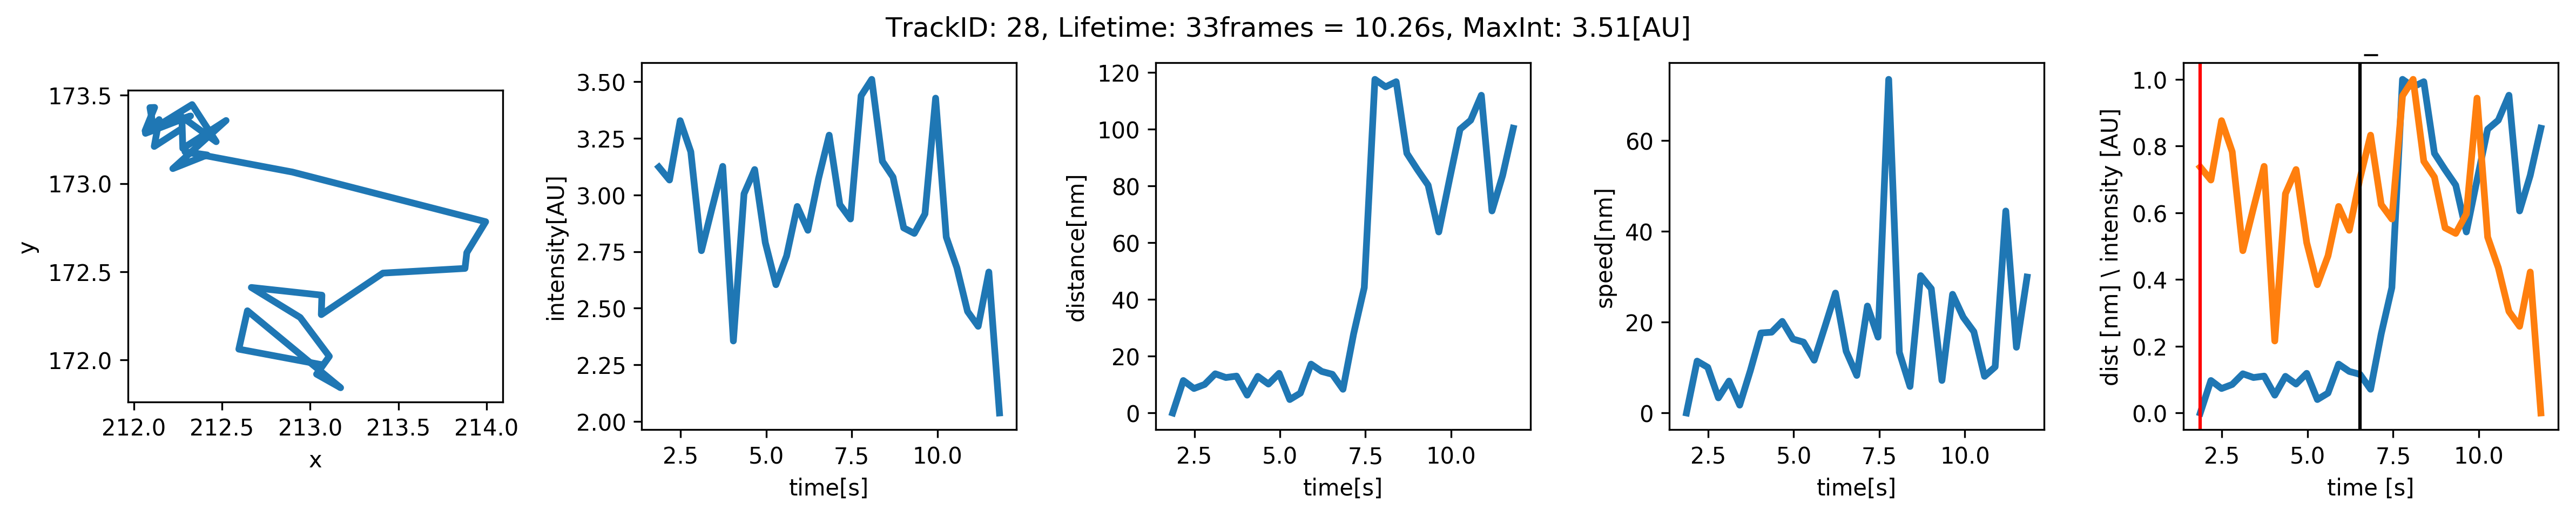

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_37_processed.csv.png


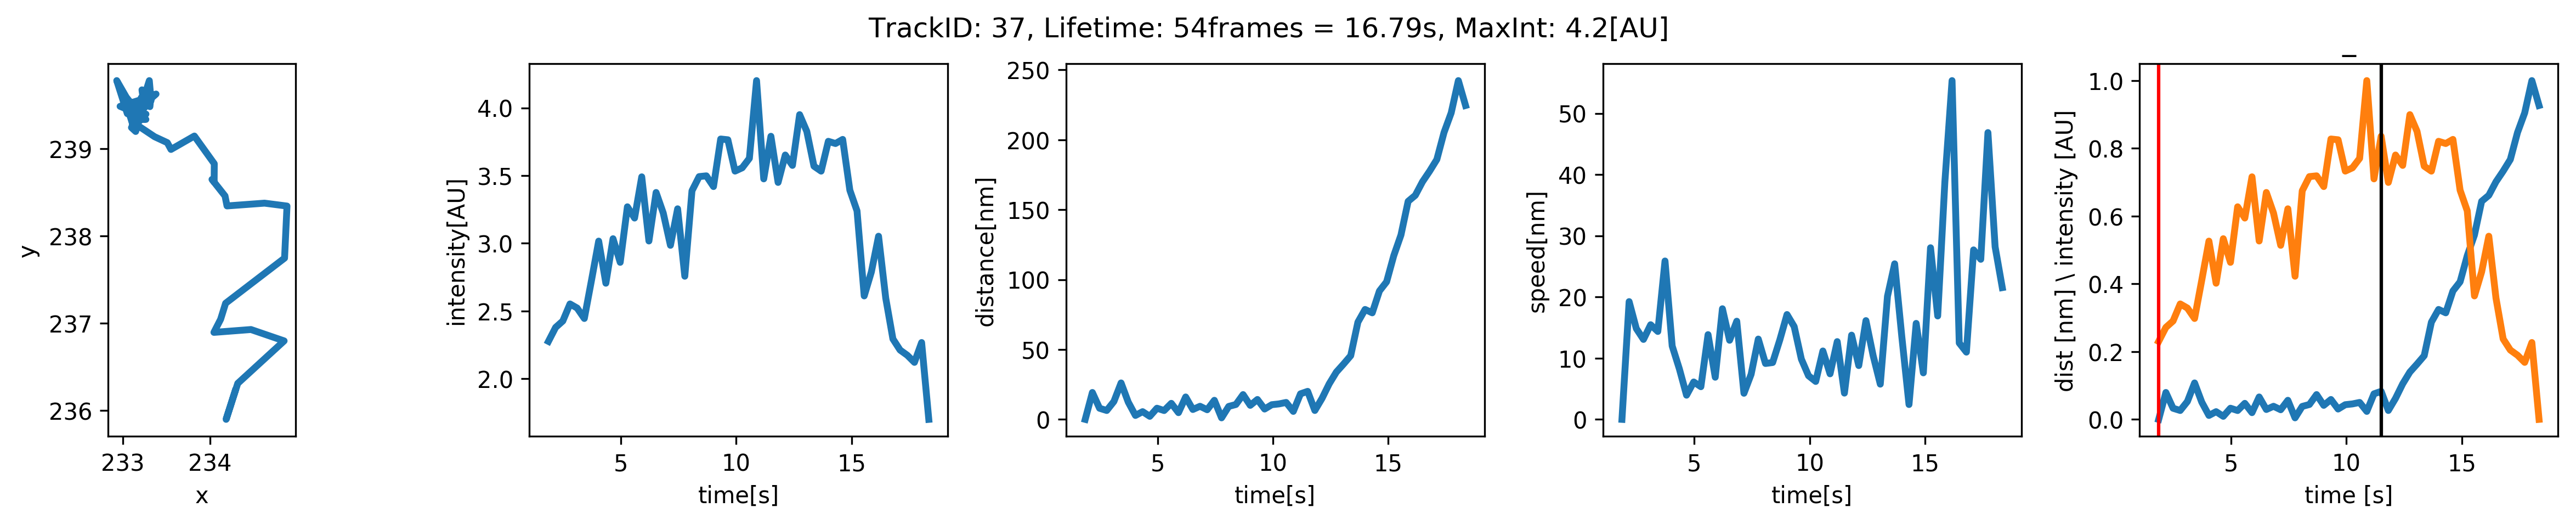

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_83_processed.csv.png


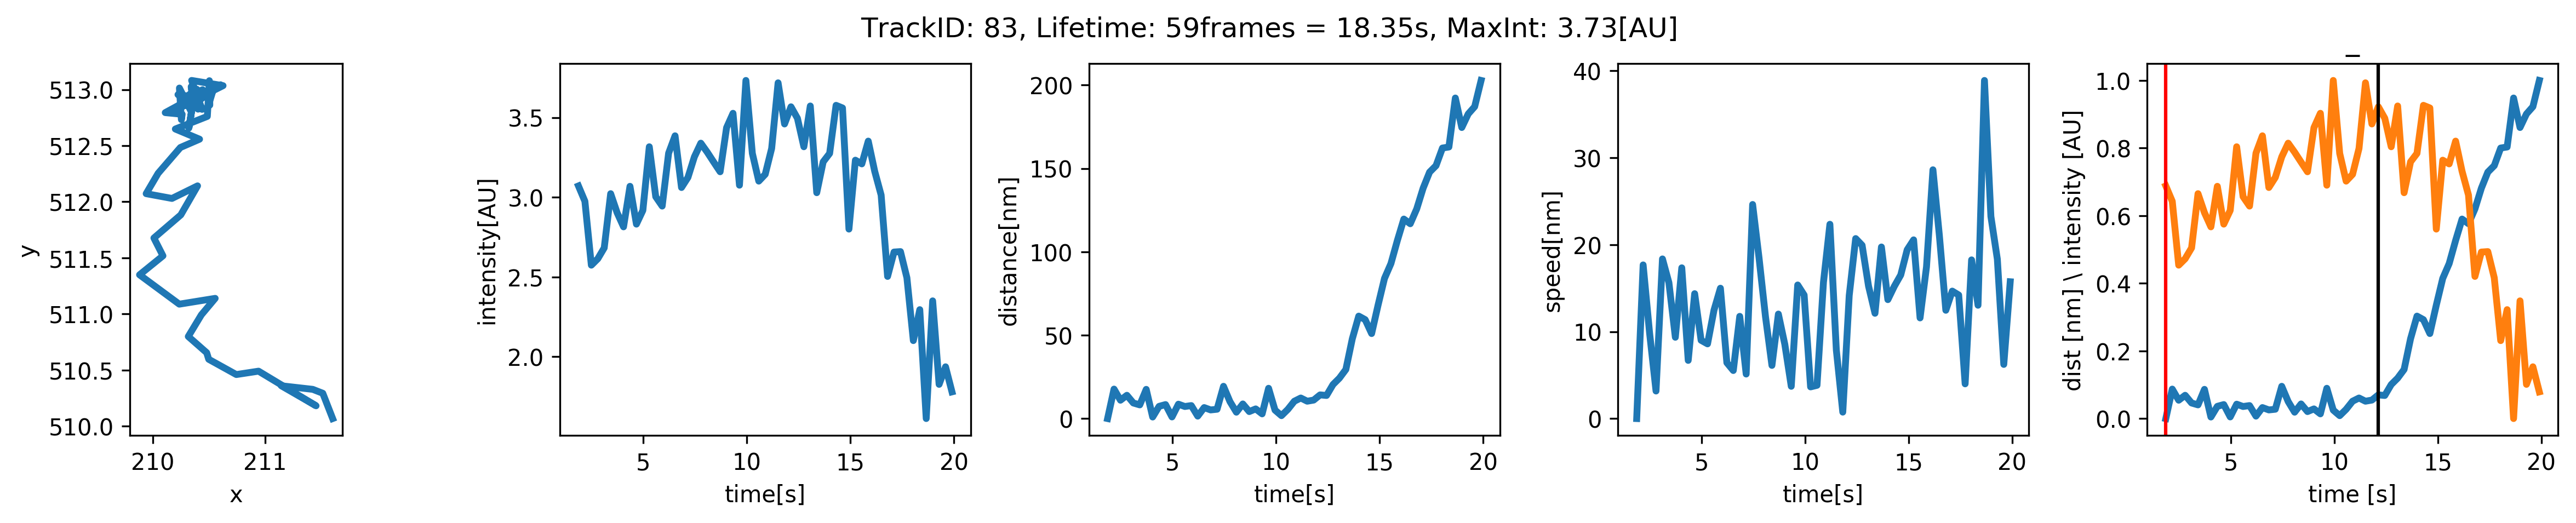

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_111_processed.csv.png


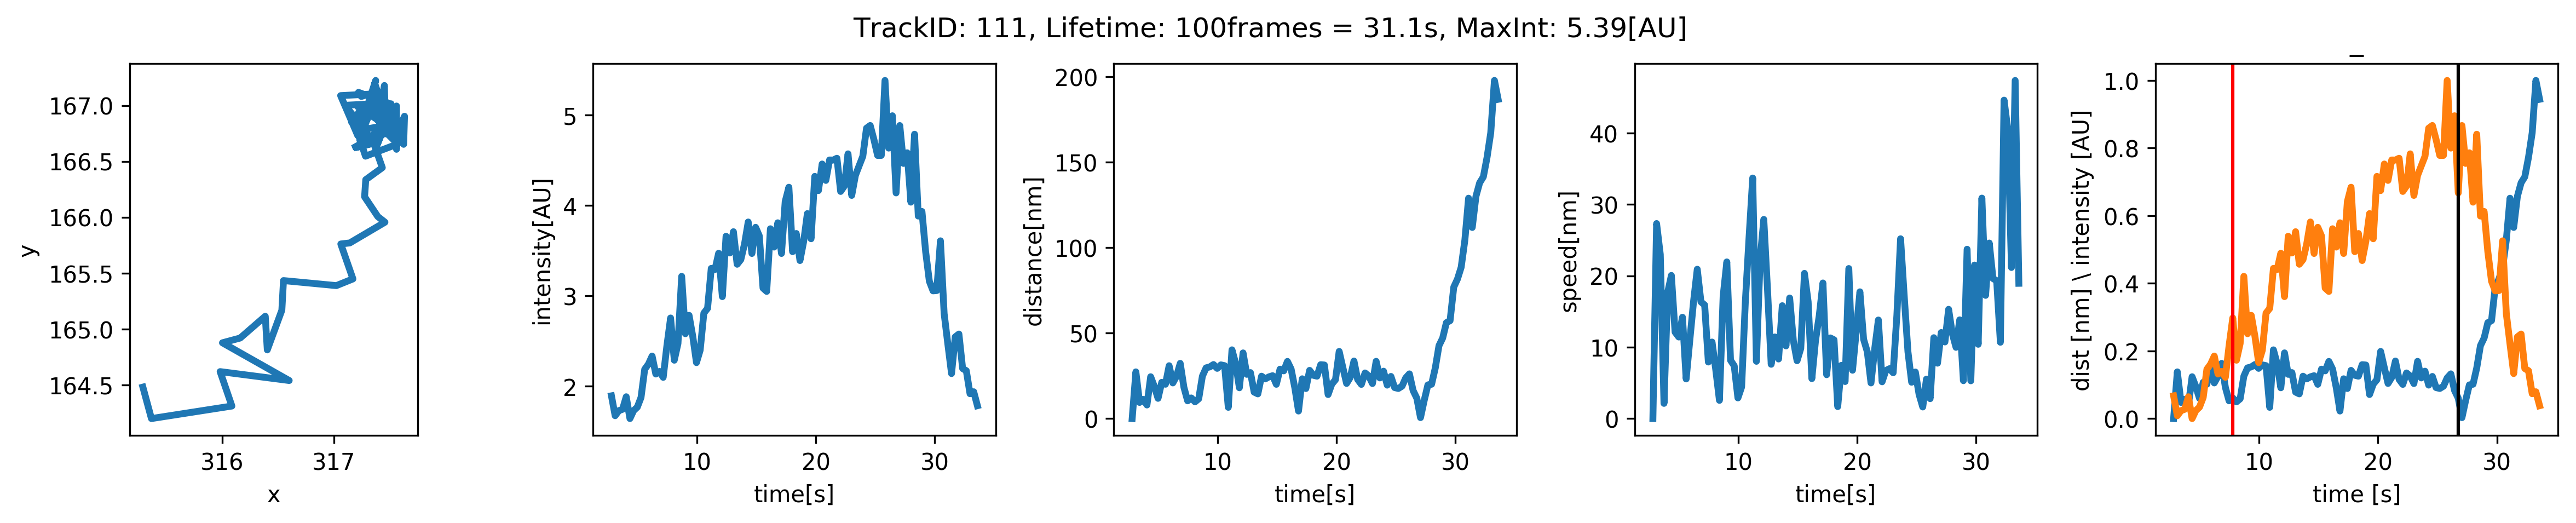

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_119_processed.csv.png


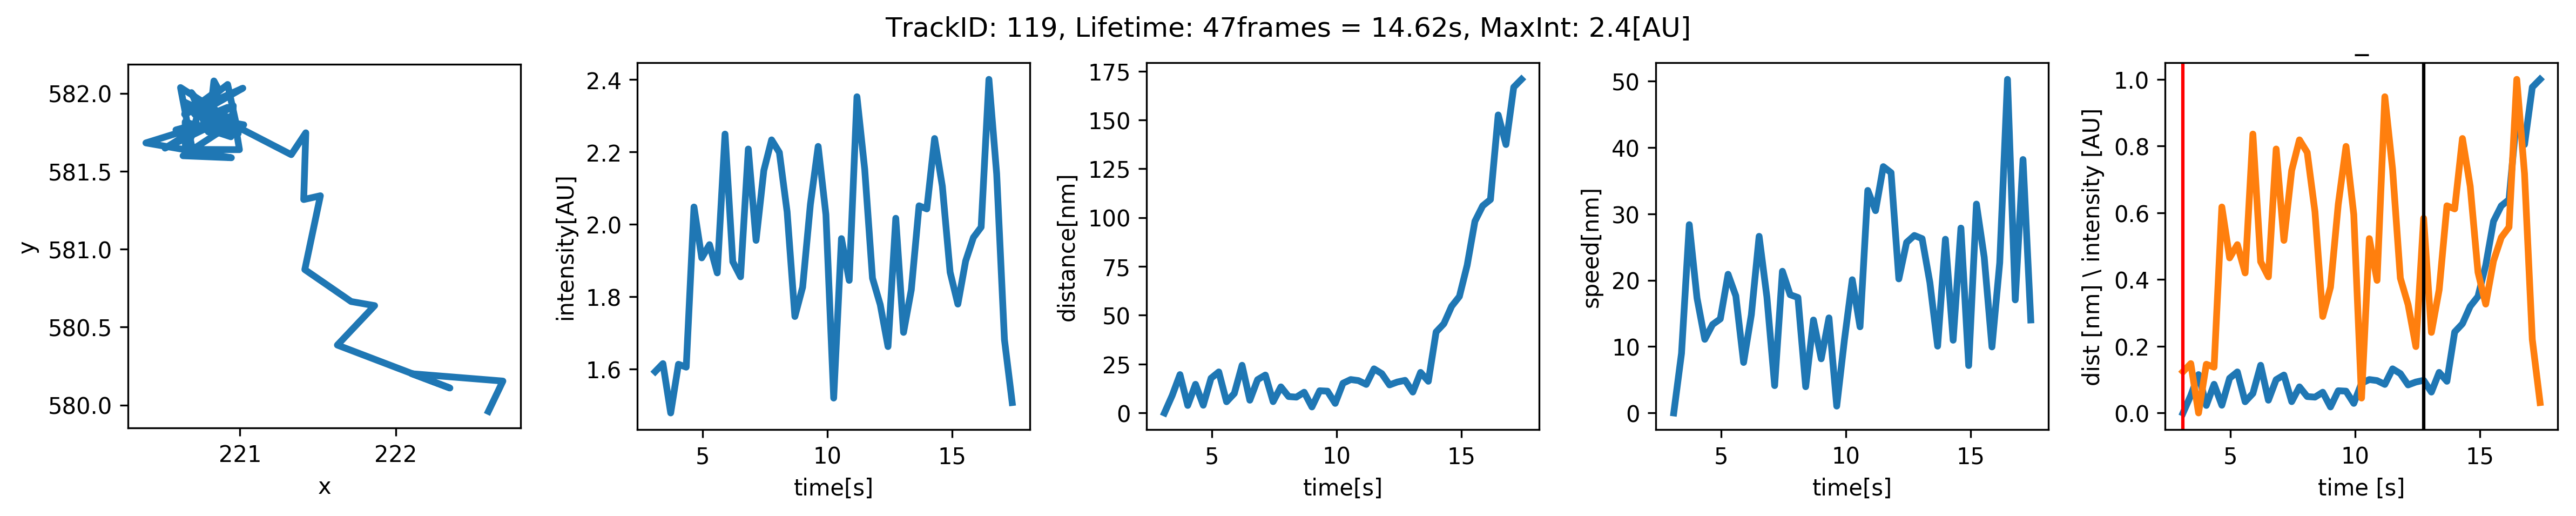

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_139_processed.csv.png


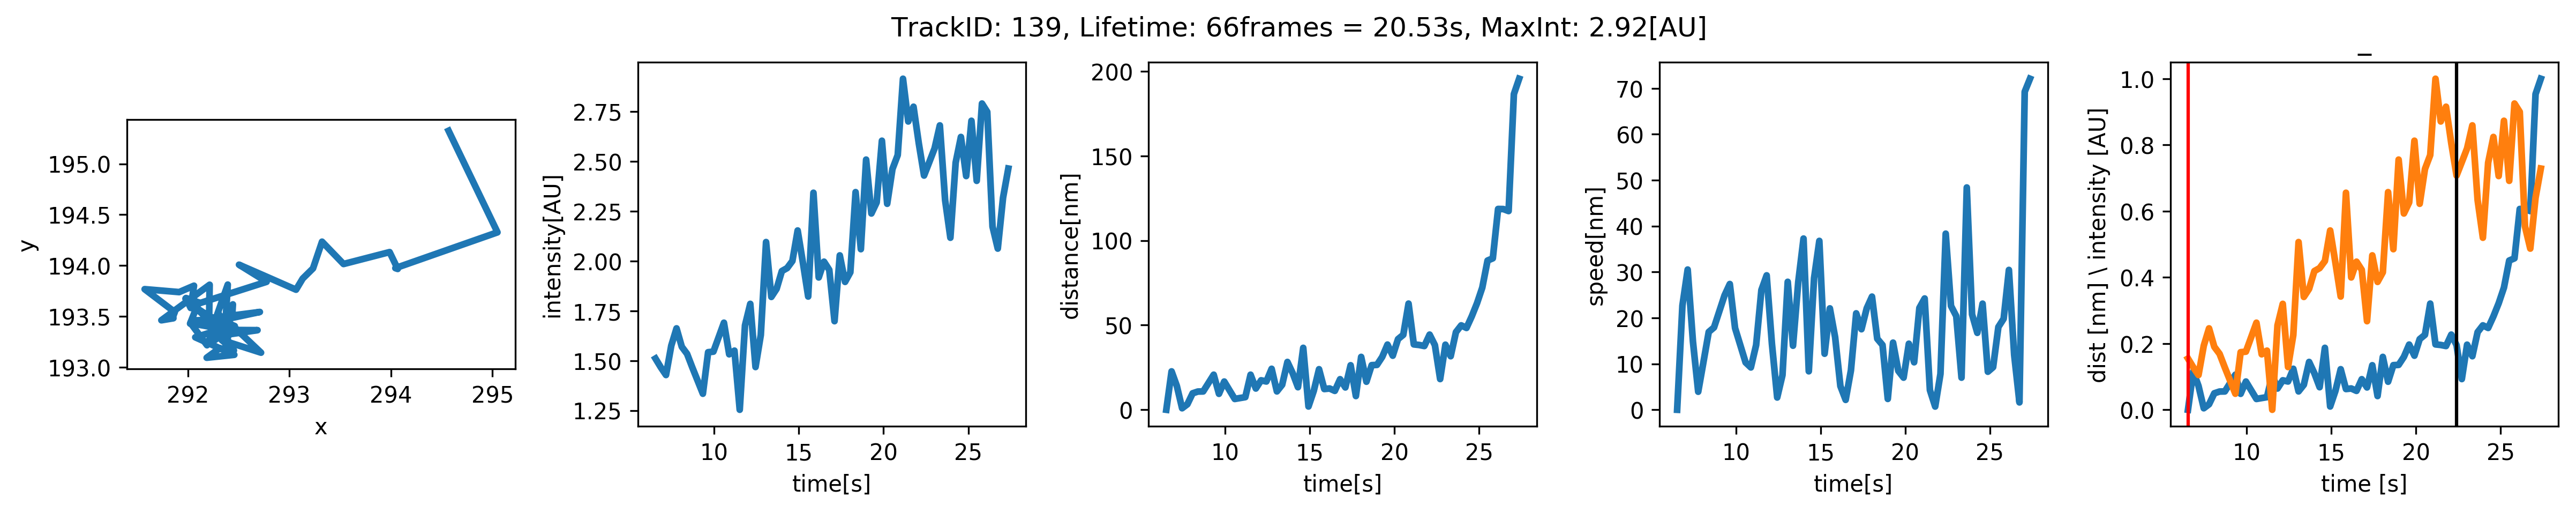

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_143_processed.csv.png


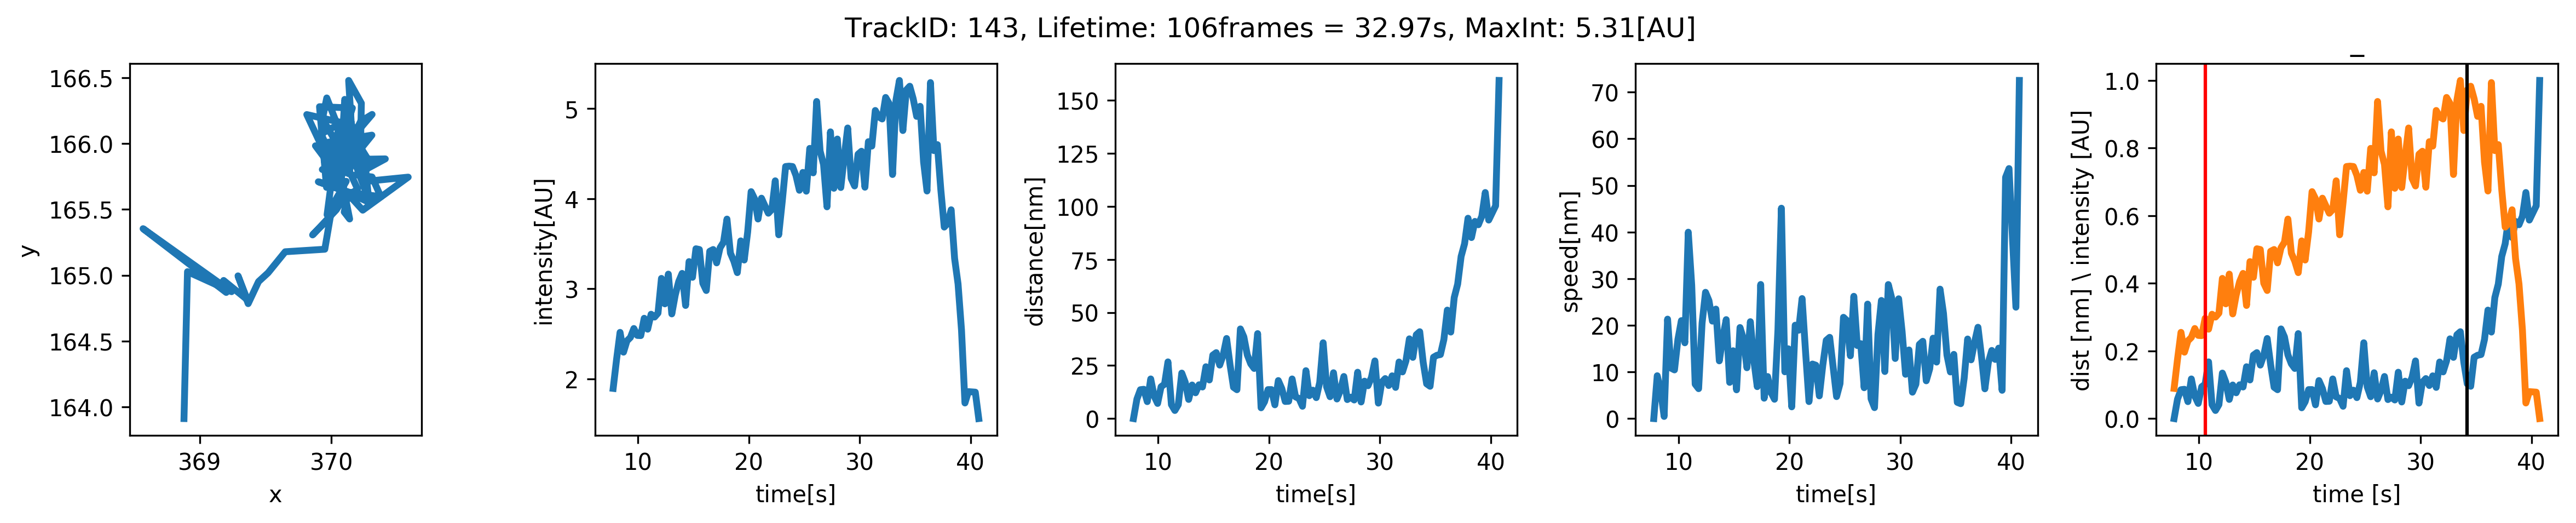

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_151_processed.csv.png


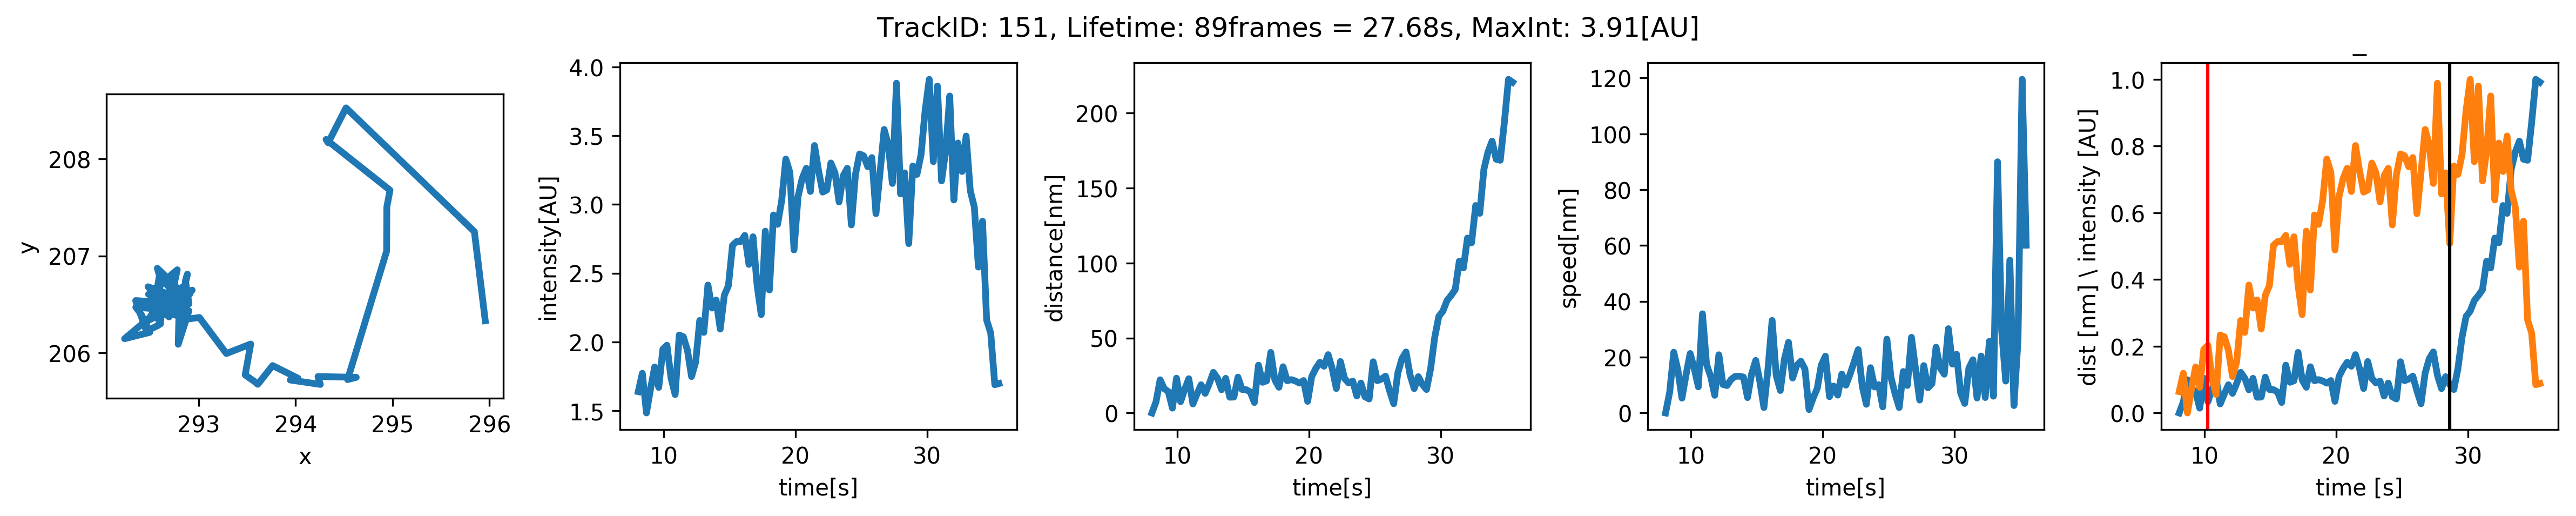

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_231_processed.csv.png


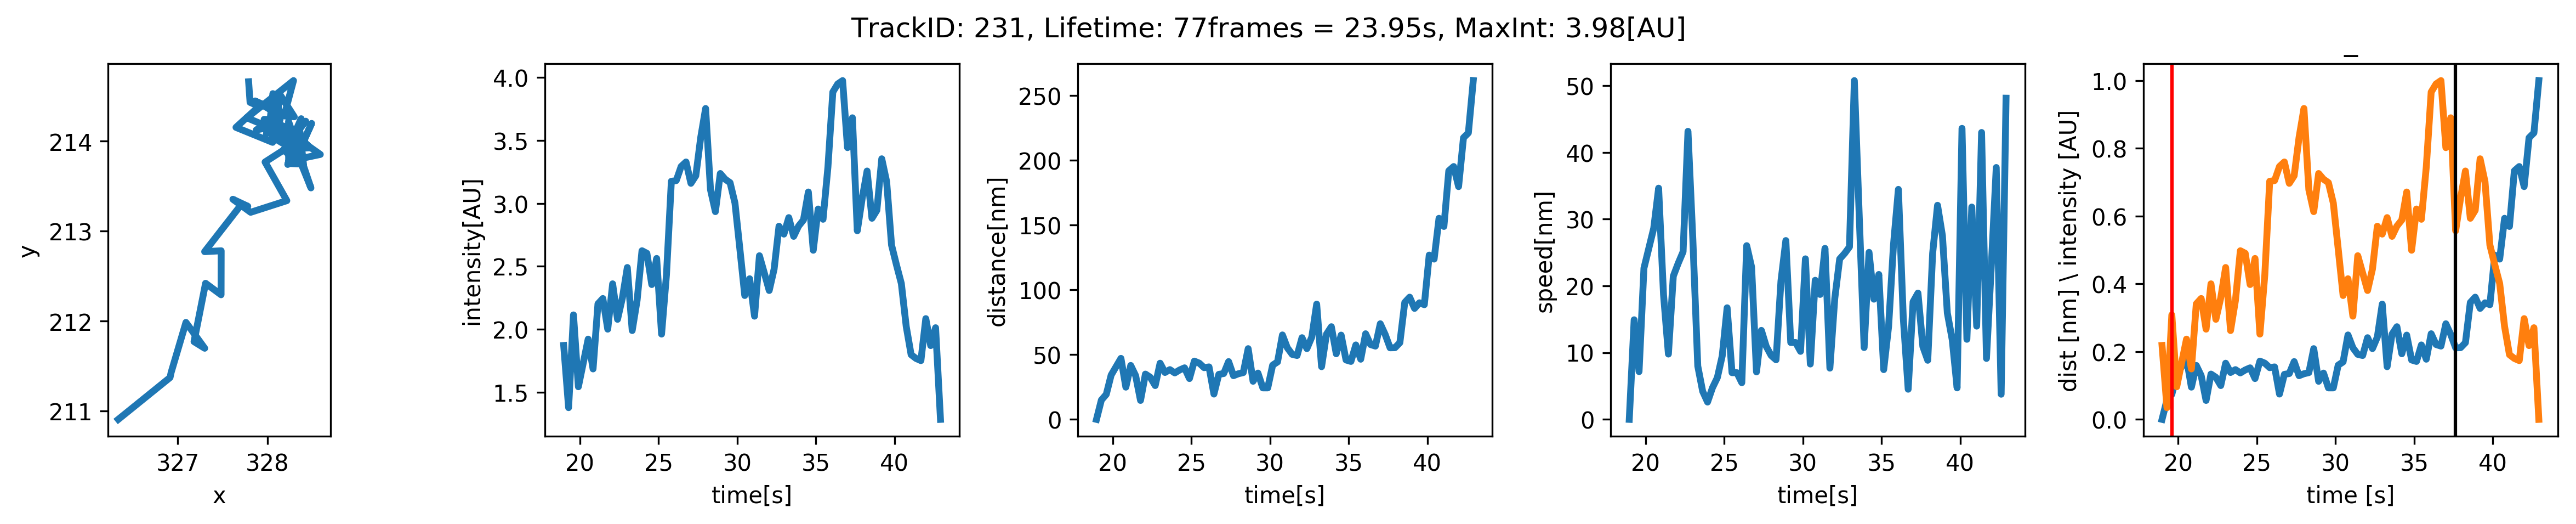

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_258_processed.csv.png


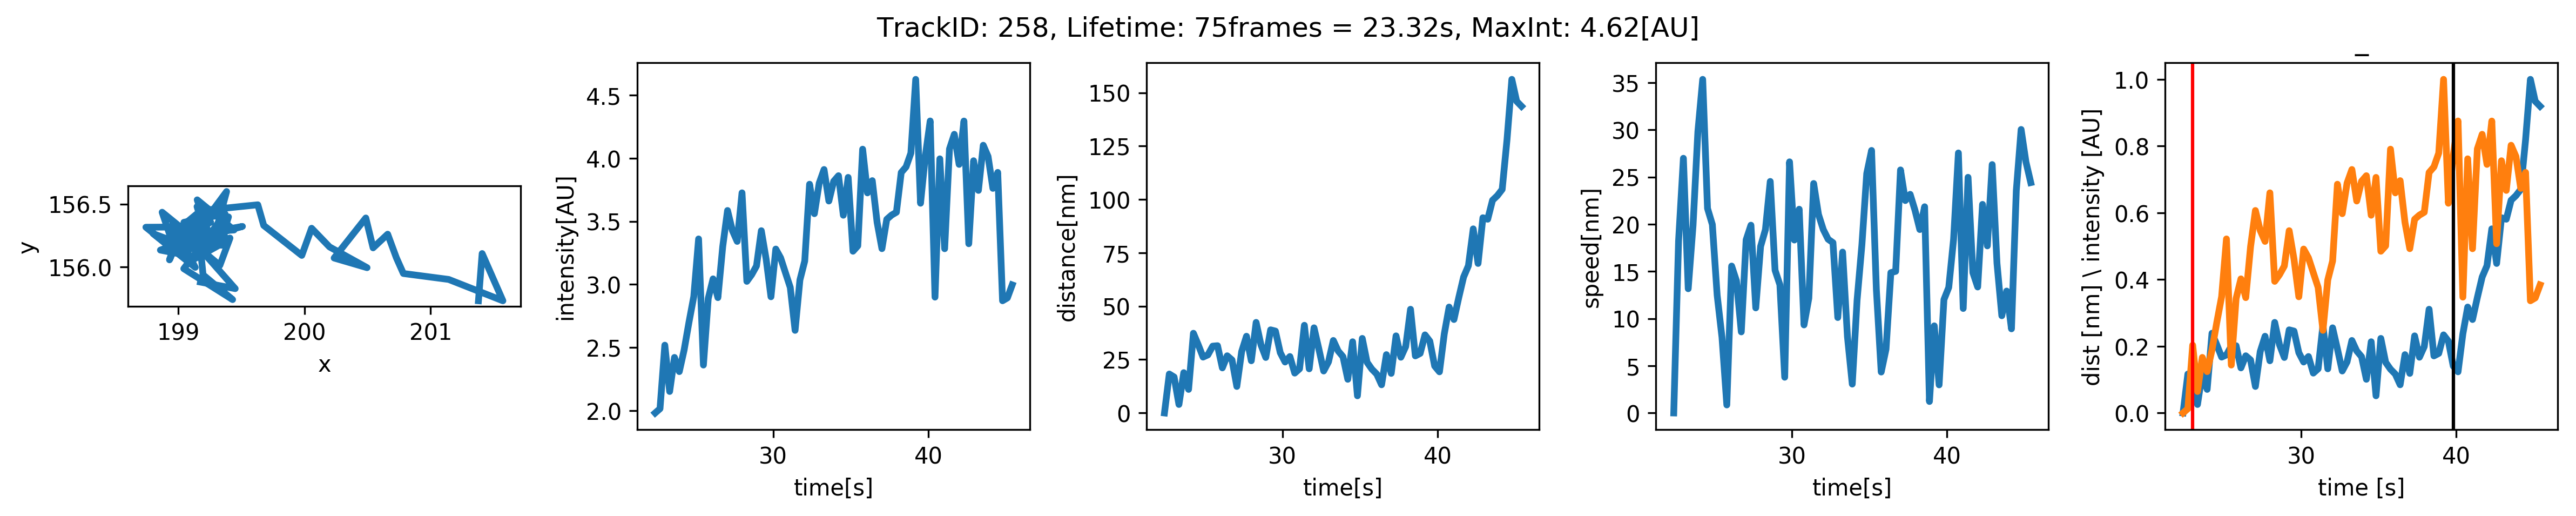

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_259_processed.csv.png


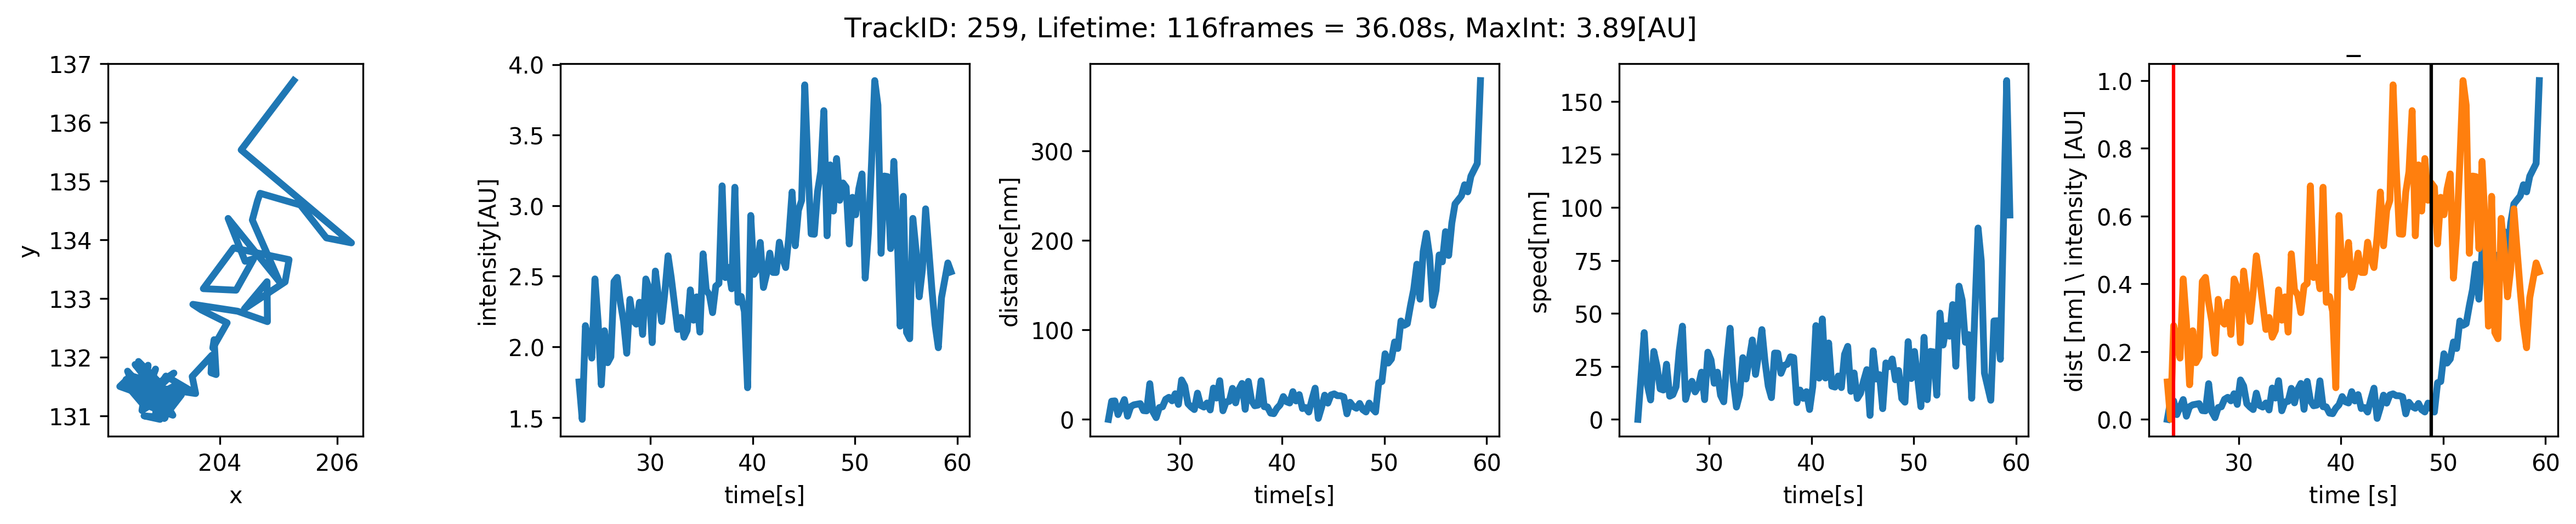

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_271_processed.csv.png


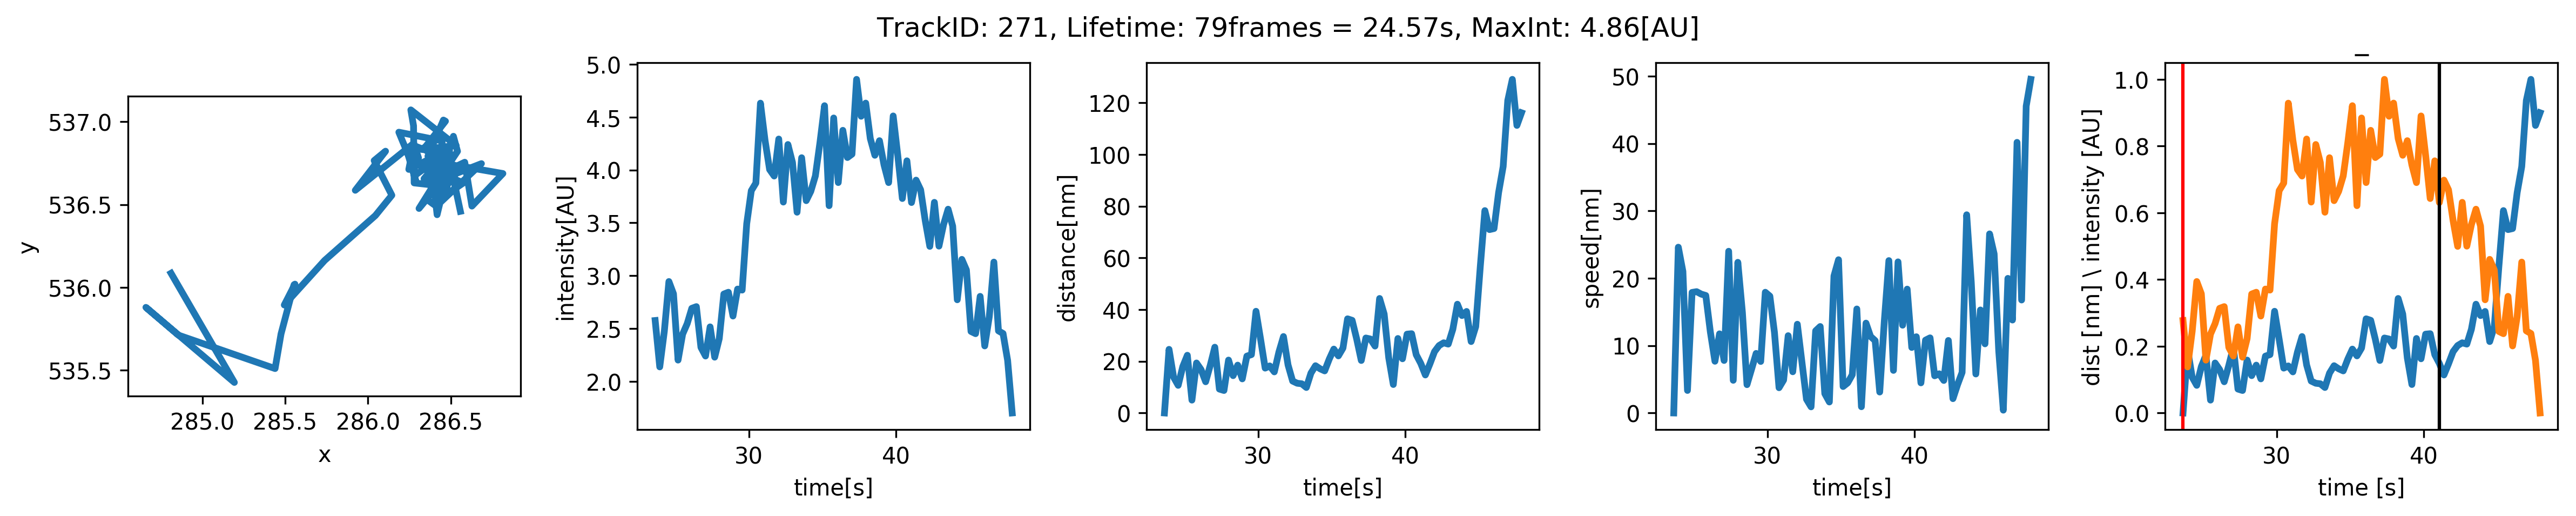

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_297_processed.csv.png


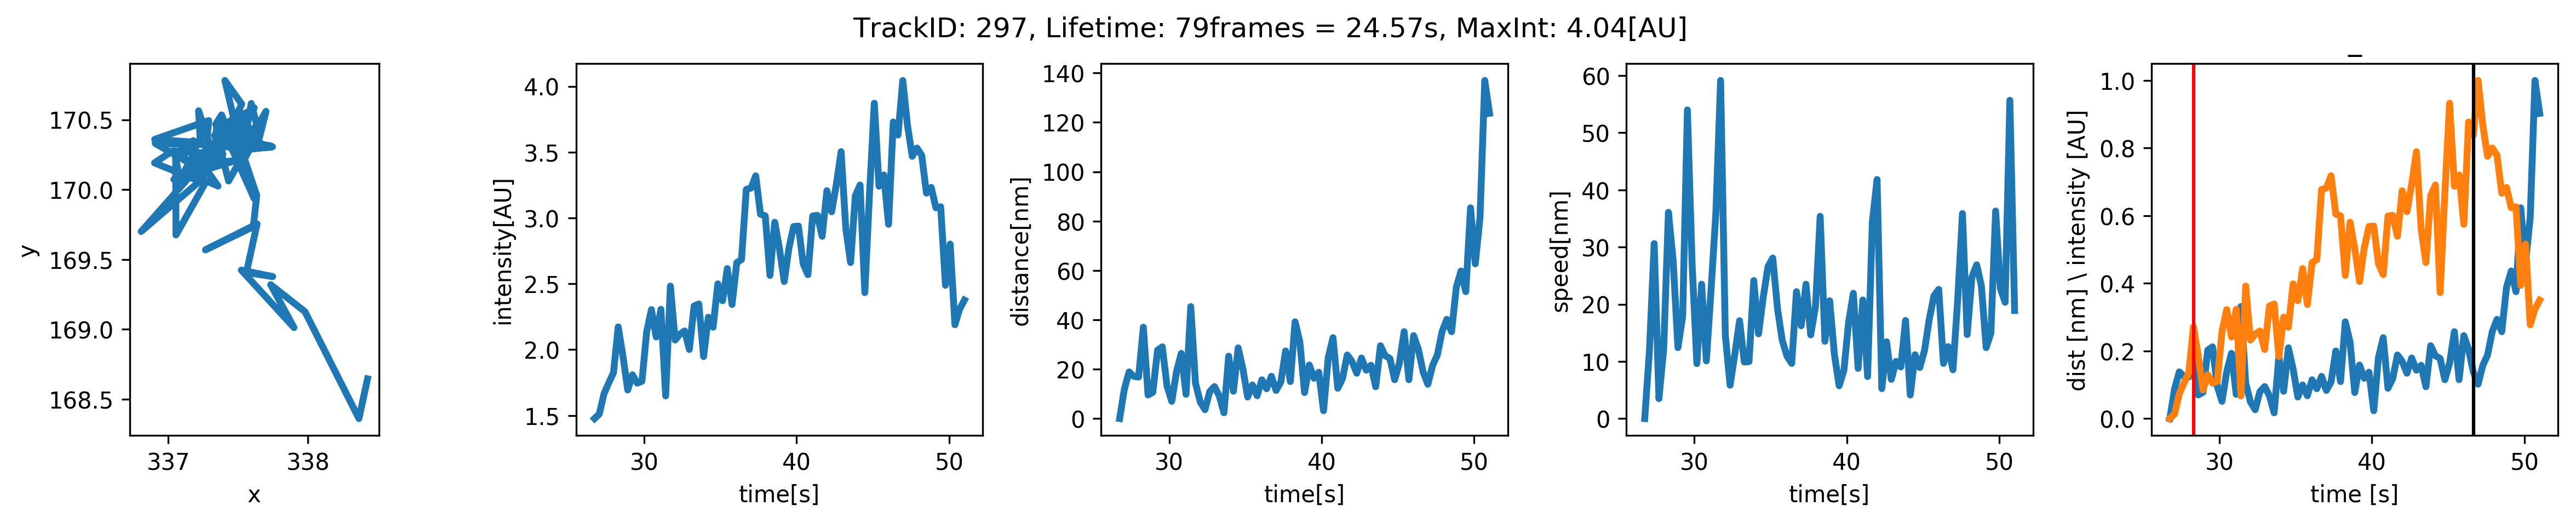

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_302_processed.csv.png


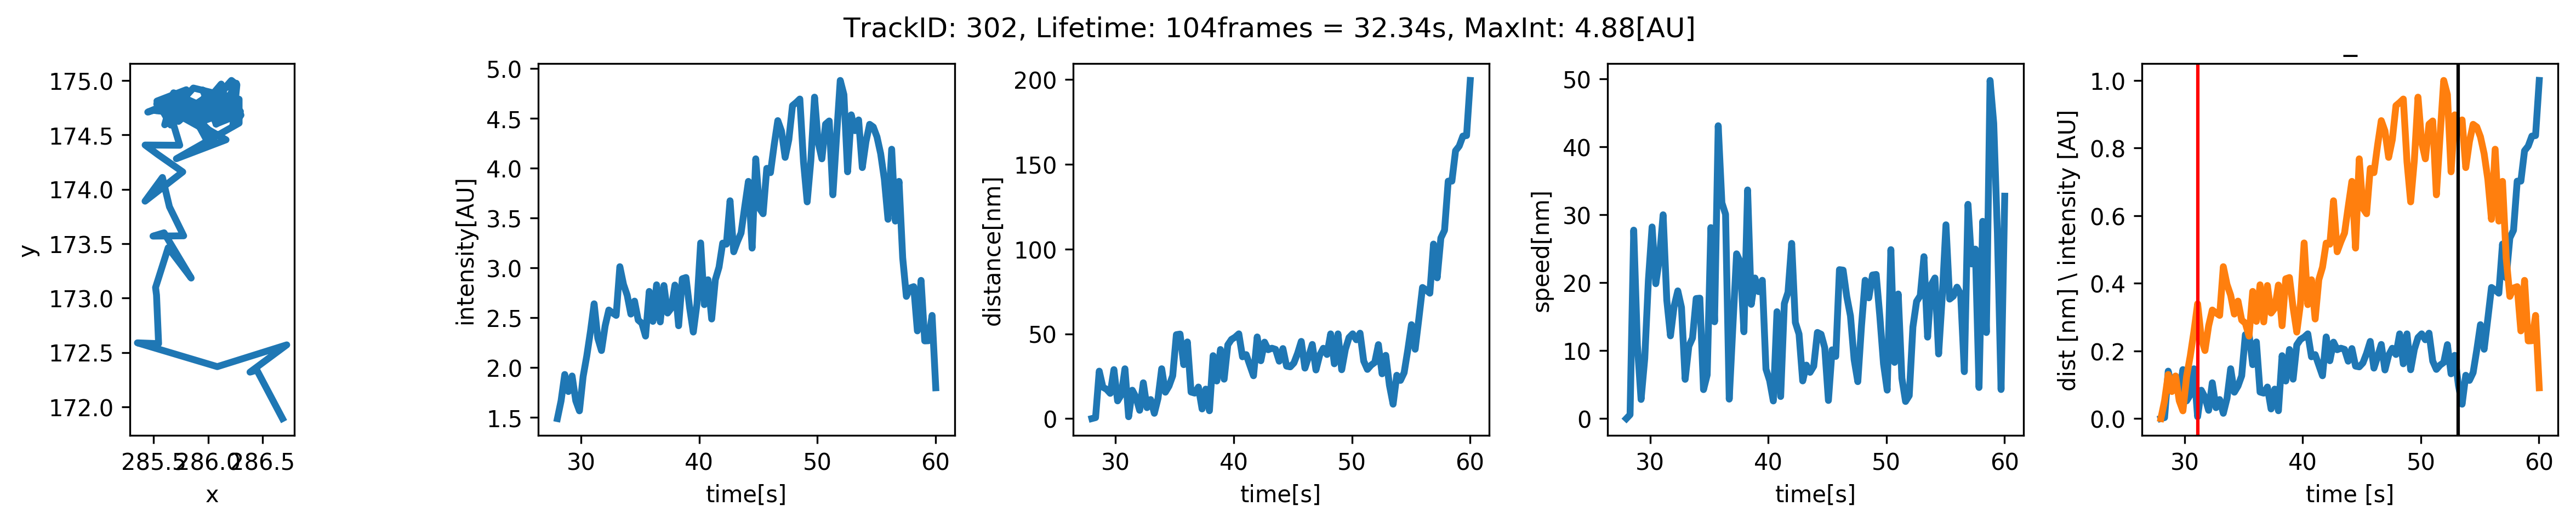

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_315_processed.csv.png


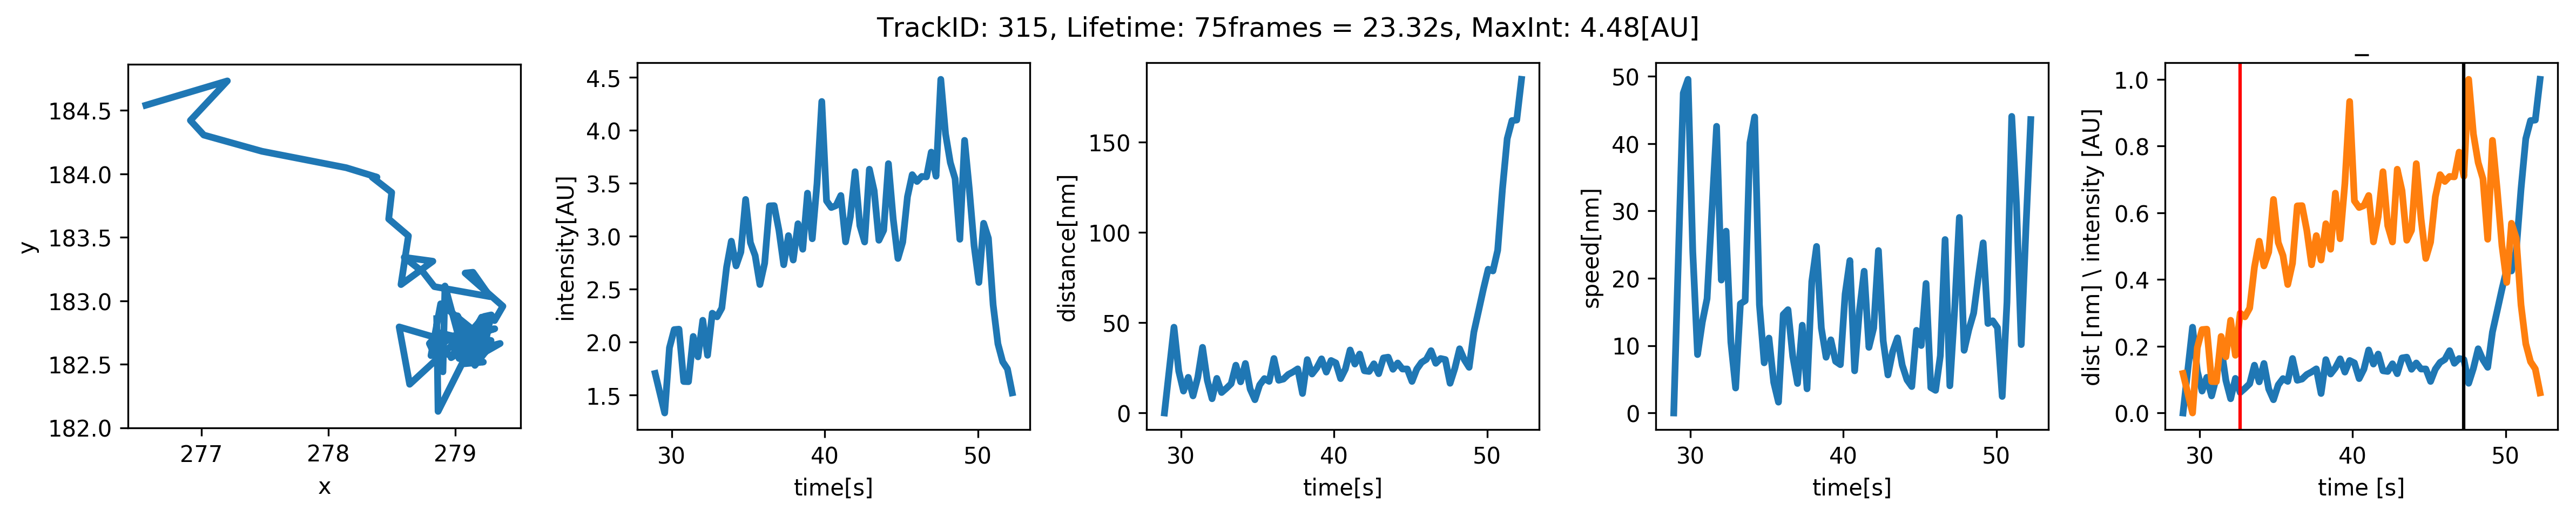

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_319_processed.csv.png


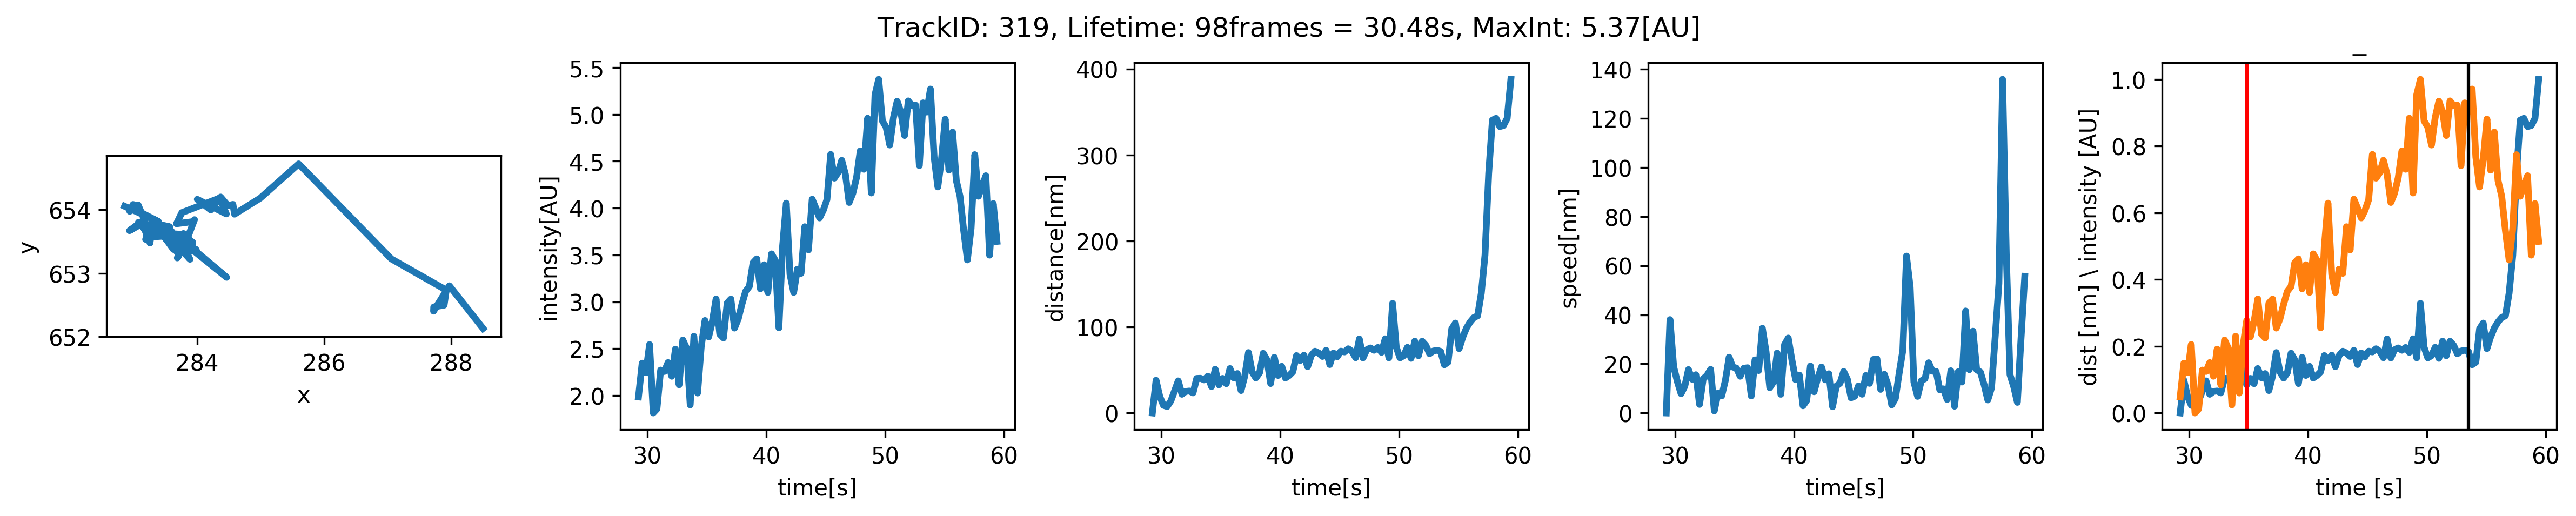

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_320_processed.csv.png


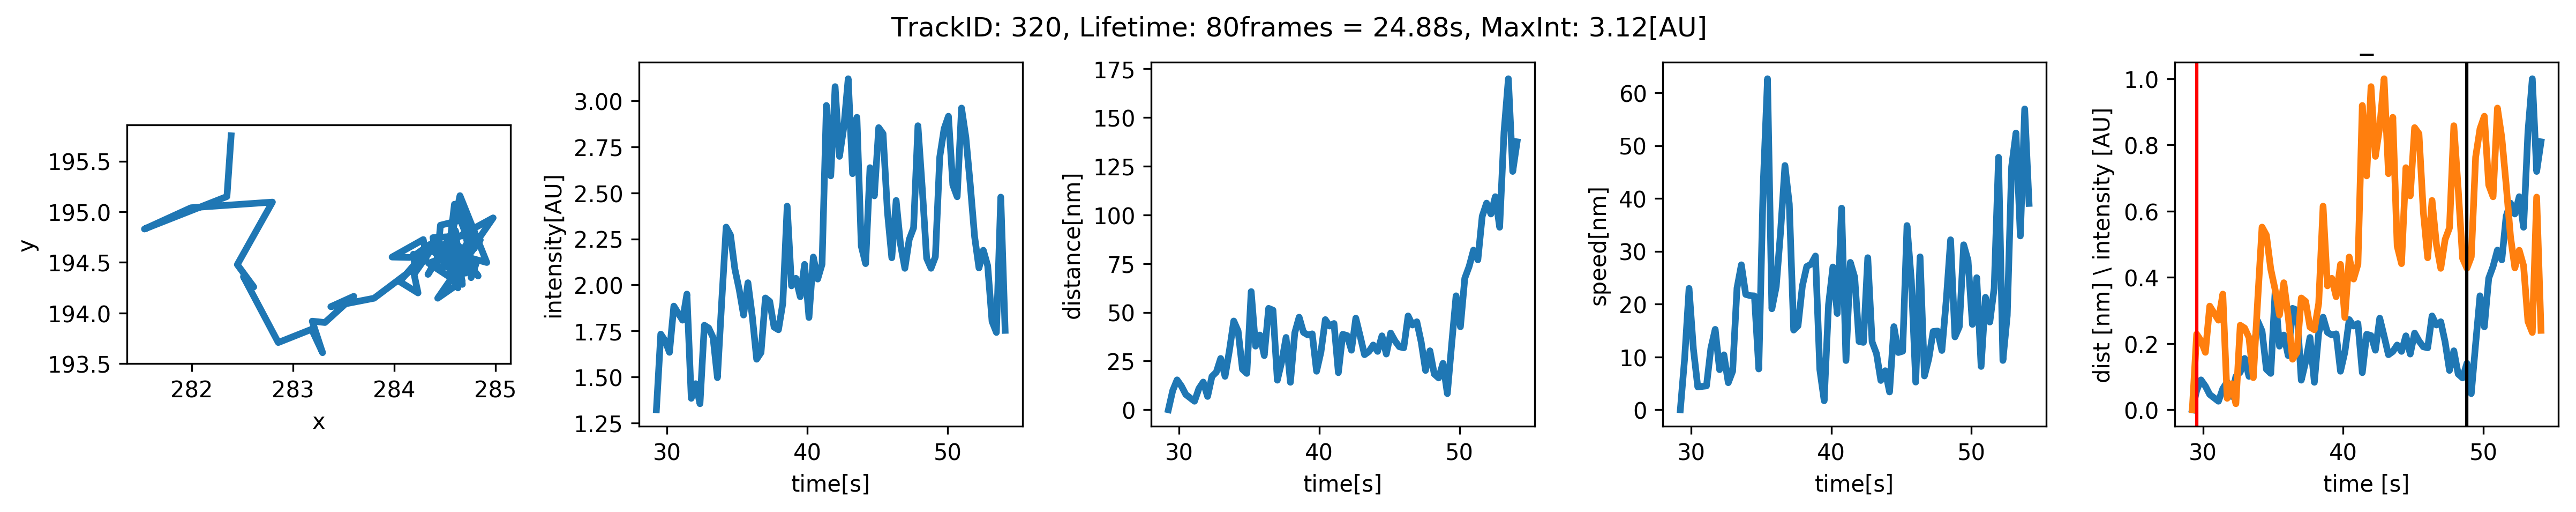

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_330_processed.csv.png


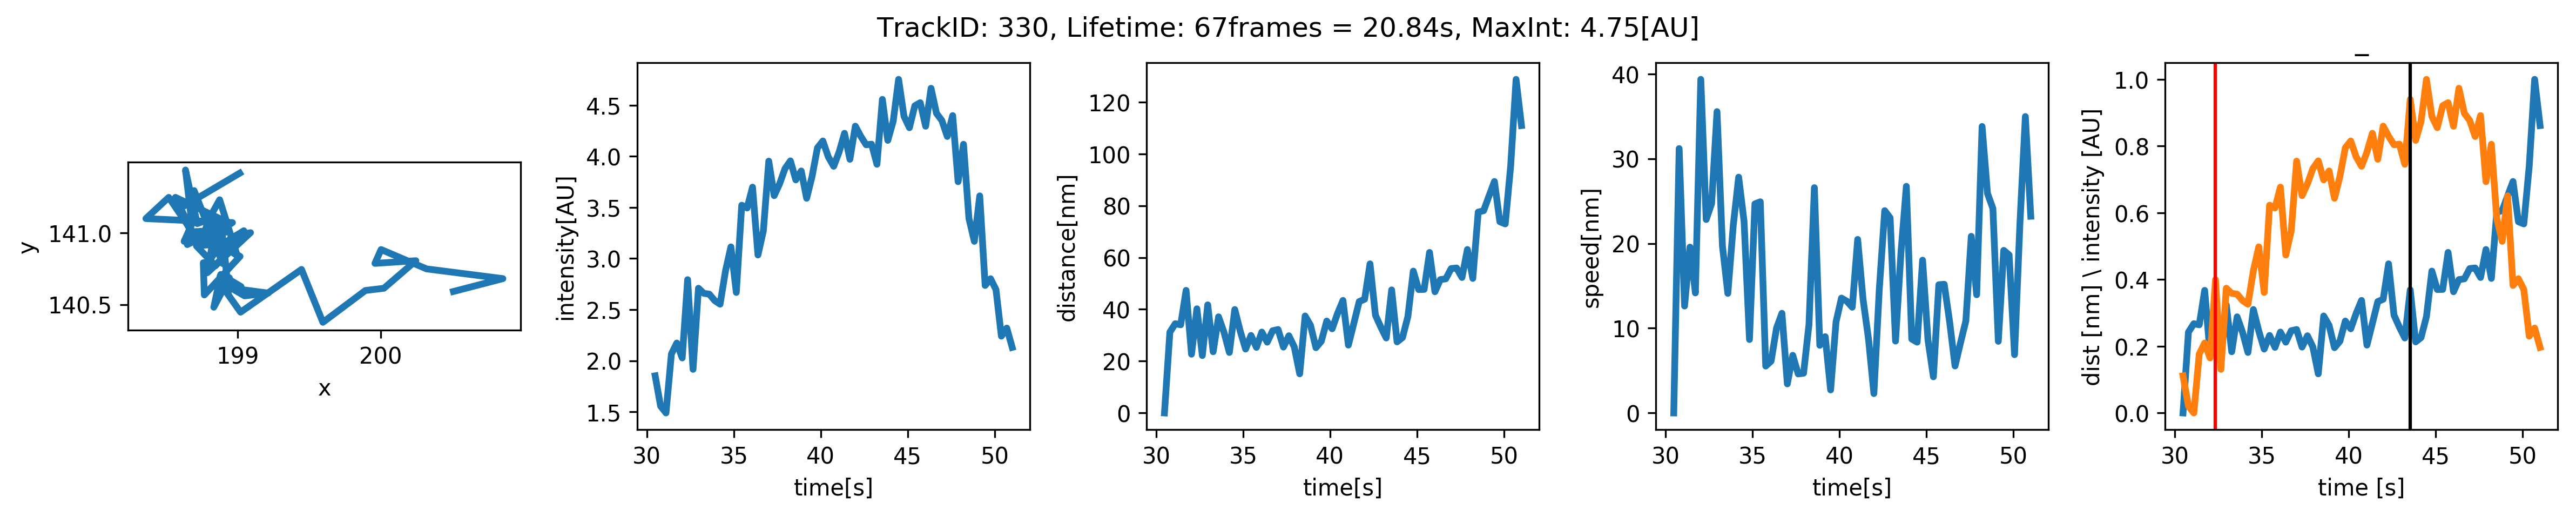

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_336_processed.csv.png


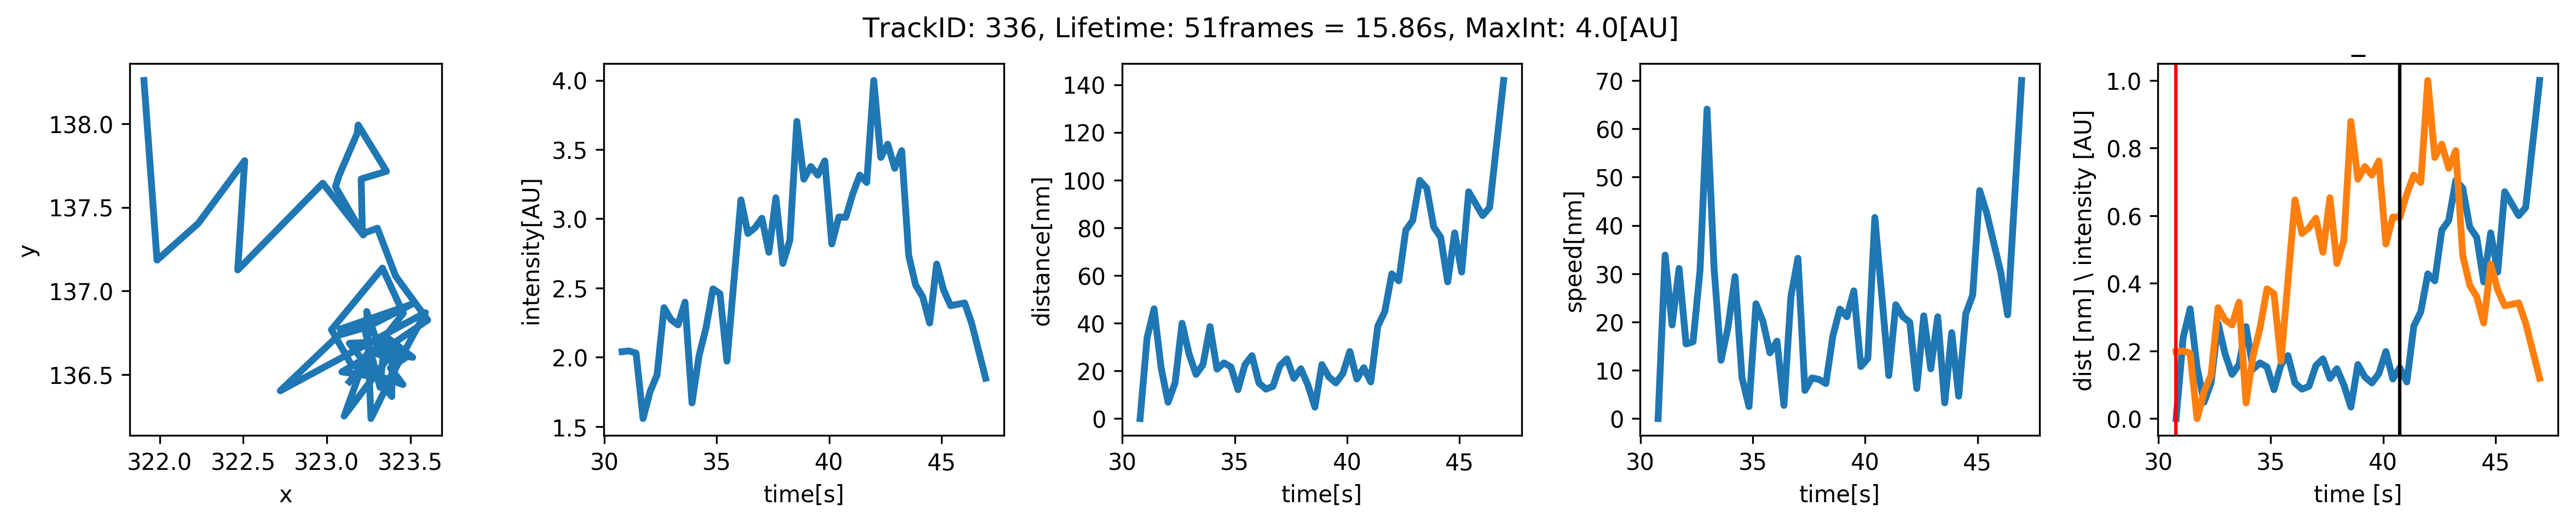

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_345_processed.csv.png


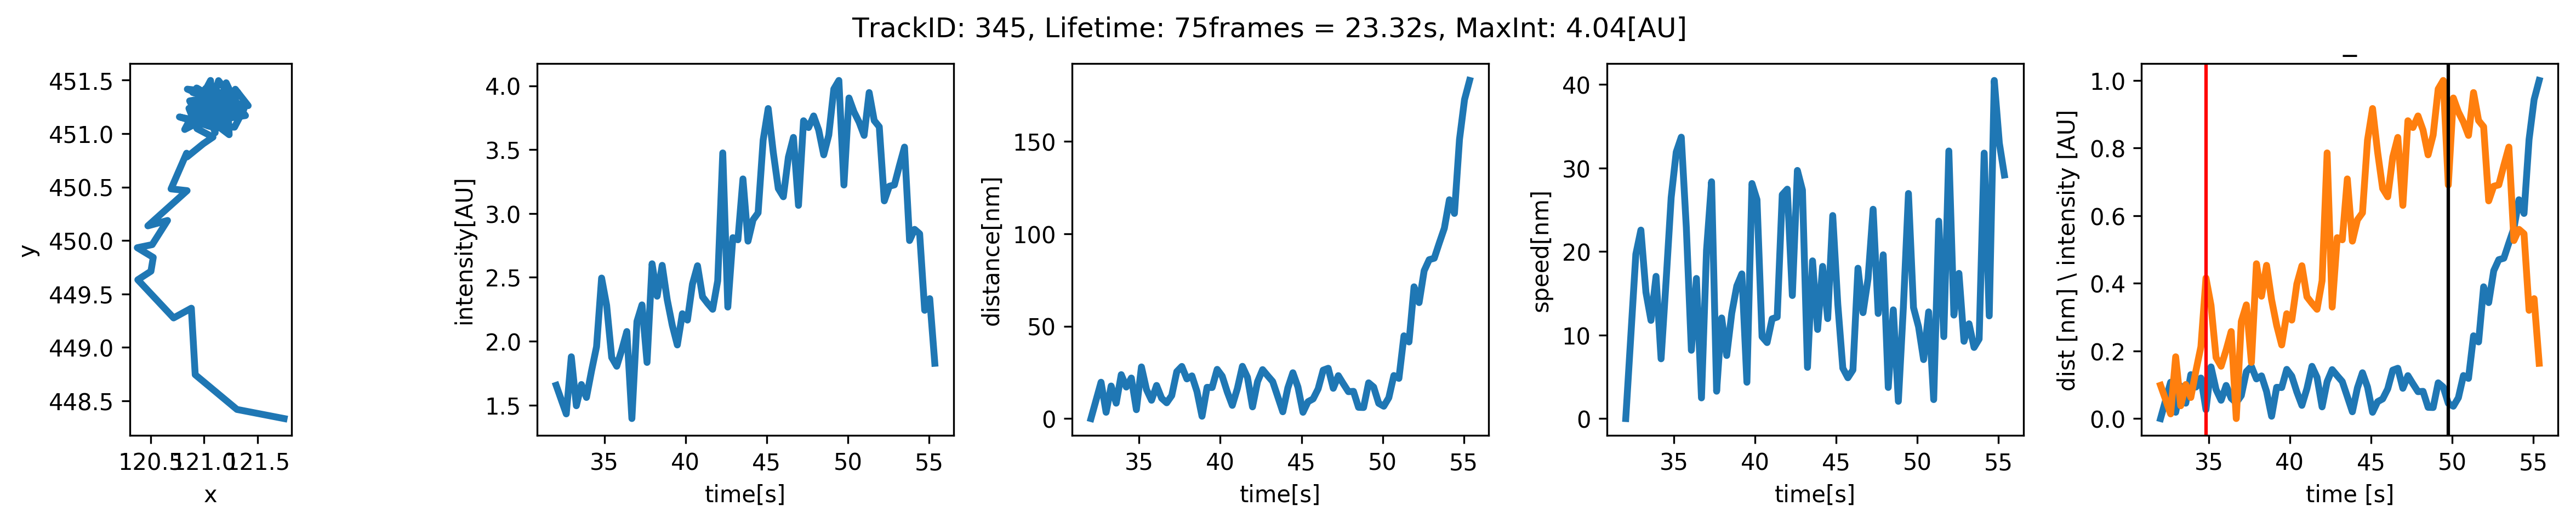

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_395_processed.csv.png


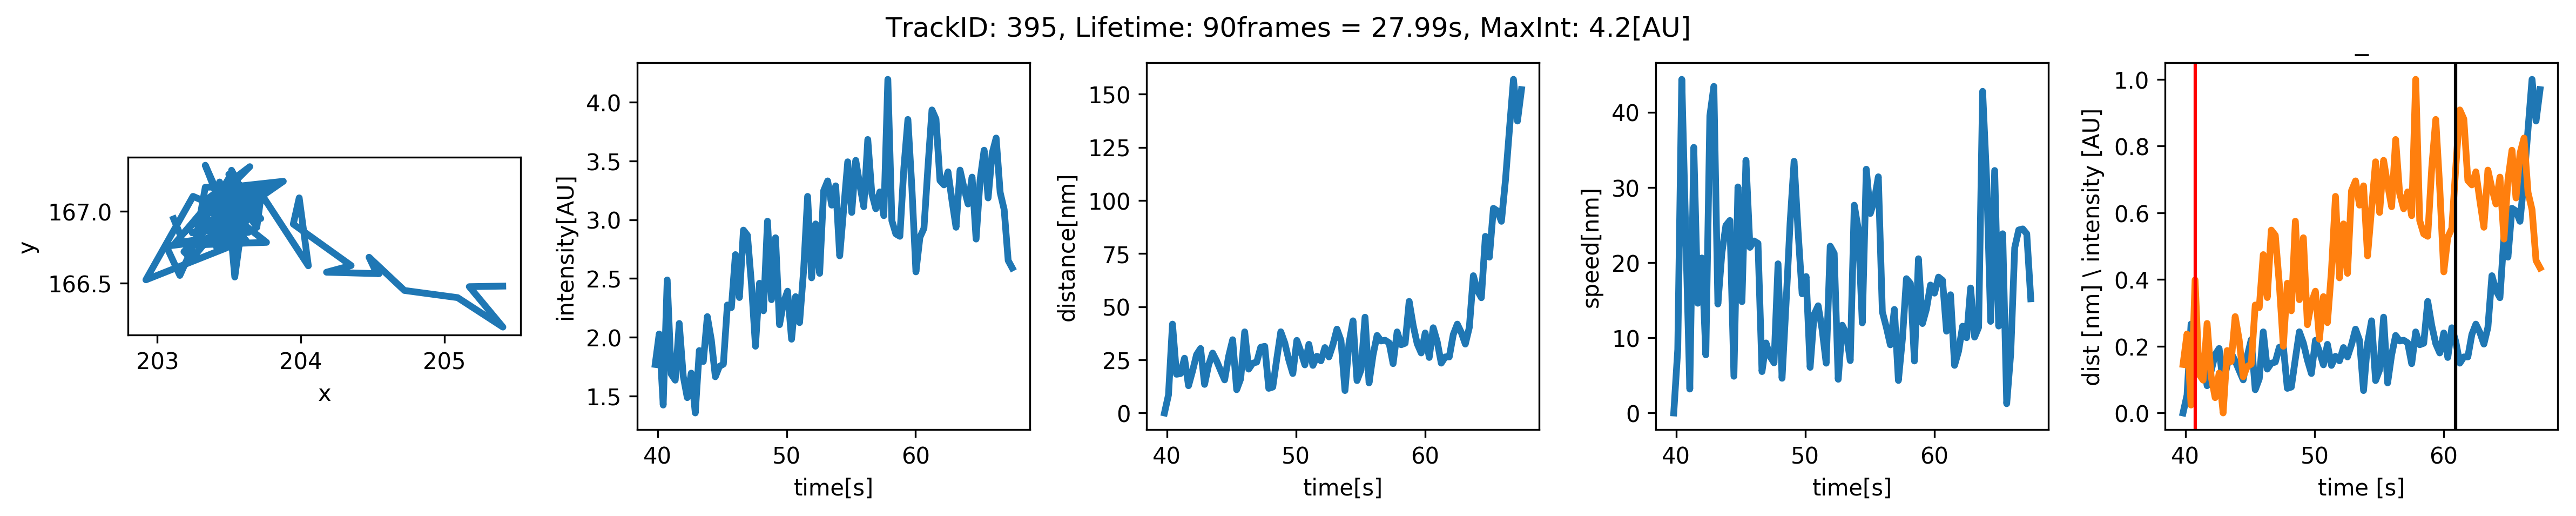

/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/end3/all_tracks.csv_461_processed.csv.png


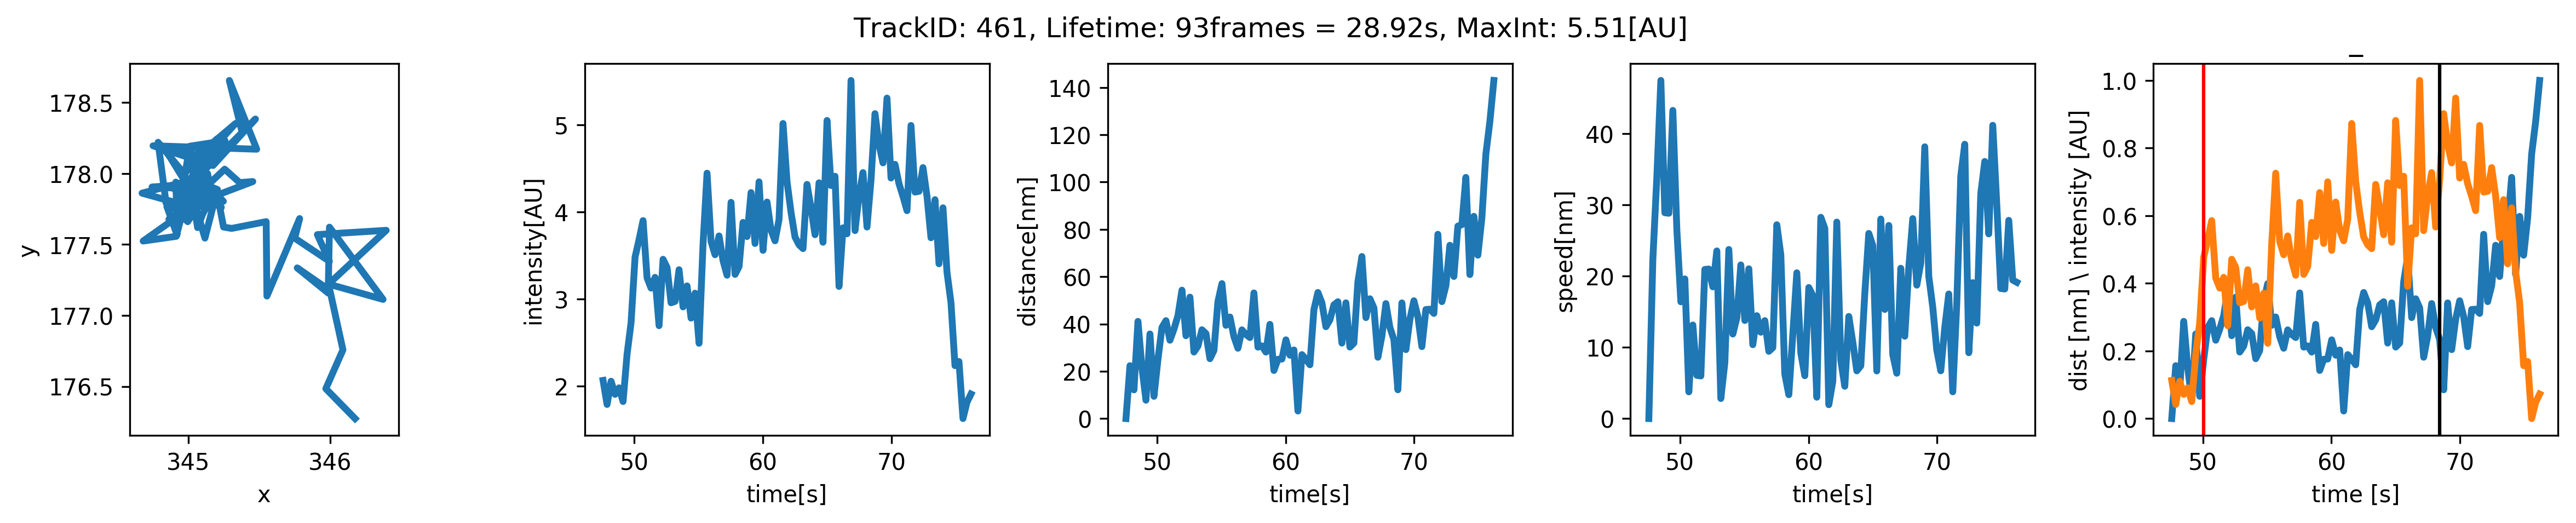

In [443]:
for outputFilePath in listOfOutputFilePaths:
    plotOverview(outputFilePath)

# just in case: For plotting one individual one by filepath

In [444]:
#plotOverview("/Users/sun.hong/Desktop/YeastTrackAnalysis-master/dataToAnalyze/fission yeast fim1-gfp/all_tracks.csv_236_processed.csv")